In [1]:
import numpy as np
from sklearn import svm
from sklearn.mixture import GaussianMixture as gmm
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import random

In [2]:
#generate the data
np.random.seed(1)
mean_1=np.array([1,1])
cov_1 = np.array([[1,0],[0,5]])
data_1 = np.random.multivariate_normal(mean_1,cov_1,100)

mean_2=np.array([-5,1])
cov_2 = np.array([[1,0],[0,5]])
data_2 = np.random.multivariate_normal(mean_2,cov_2,100)


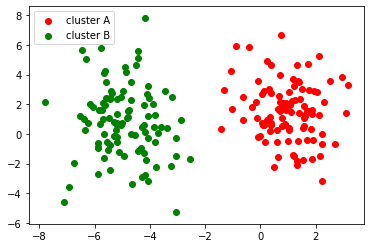

In [3]:
#visualize

plt.scatter(data_1[:,0],data_1[:,1],color = 'red', label ='cluster A')
plt.scatter(data_2[:,0],data_2[:,1],color ='green', label = 'cluster B')
plt.legend()
plt.show()

In [4]:
#run EM mixture model
em = gmm(n_components=2) 
total_data = np.concatenate((data_1,data_2),axis=0)
em.fit(total_data)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [5]:
#print its parameters
print('EM means:', em.means_)
print('EM cov:', em.covariances_)

EM means: [[ 0.98888854  1.50745425]
 [-4.93112983  0.83000007]]
EM cov: [[[ 0.88542891 -0.25767387]
  [-0.25767387  3.69237505]]

 [[ 1.02589299 -0.23909752]
  [-0.23909752  5.5887969 ]]]


In [6]:
#create kernel matrix
weights,means,covariances = em.weights_, em.means_, em.covariances_
def get_responsibility_matrix(data,em): #this gives me the whole responsibility matrix
    weights,means,covariances = em.weights_, em.means_, em.covariances_
    N = data.shape[0]
    K = means.shape[0]
    result = np.zeros((N,K))
    
    for i in range(0, N):
        denom = 0
        for j in range(0,K):
            result[i][j] = weights[j] * multivariate_normal(means[j],covariances[j]).pdf(data[i])
            denom += result[i][j]
        result[i] = result[i]/denom
    return result

def create_Marginilized_Kernel(data,em,responsibility): #gives me the whole kernel matrix
    covariances = em.covariances_
    N = data.shape[0]
    K = covariances.shape[0]
    result = np.zeros((N,N))
    for i in range(0,N):
        for j in range(0,N):
            
            for q in range(0,K):
                result[i][j] += responsibility[i][q] * responsibility[j][q] * np.dot(data[i], np.dot(np.linalg.inv(covariances[q]),data[j]))
    return result

r = get_responsibility_matrix(total_data,em)

def responsibility(x,q): #gives me the singular responsibility r[x][q]
    denom = 0
    K = weights.shape[0]
    result = np.zeros(K)
    for j in range(0,K):
        
        result[j] = weights[j] * multivariate_normal(means[j],covariances[j]).pdf(x)
        denom += result[j]
    result = result/denom
    return result[q]
    
def marginilized_Kernel(x,y): #gives me the singular kernel element K(x,y)
    covariances = em.covariances_
    K = covariances.shape[0]
    
    result = 0
    
    for q in range(0,K):
        result += responsibility(x,q) * responsibility(y,q) * np.dot(x, np.dot(np.linalg.inv(covariances[q]),y))
    return result


In [7]:
# compute the kernel

r = get_responsibility_matrix(total_data,em)
kernel = create_Marginilized_Kernel(total_data,em,r)

print(kernel)

[[ 6.39469022e+00 -2.97307587e-01  2.75045681e+00 ... -1.34764325e-06
  -1.74552953e-06 -1.65085545e-03]
 [-2.97307587e-01  1.73218673e-02 -3.52621696e-02 ...  9.49119212e-06
   1.09271618e-05  3.36779413e-04]
 [ 2.75045681e+00 -3.52621696e-02  3.63467480e+00 ...  4.91825939e-02
   3.70384947e-02  4.96820430e-02]
 ...
 [-1.34764325e-06  9.49119212e-06  4.91825939e-02 ...  1.81669182e+01
   1.84172811e+01  1.17265709e+01]
 [-1.74552953e-06  1.09271618e-05  3.70384947e-02 ...  1.84172811e+01
   1.93179302e+01  1.12882422e+01]
 [-1.65085545e-03  3.36779413e-04  4.96820430e-02 ...  1.17265709e+01
   1.12882422e+01  8.12584374e+00]]


In [8]:
# pick three examples

#pick two from green:
np.random.seed(1)
a = np.arange(data_2.shape[0])
np.random.shuffle(a)

two_examples = data_2[a[:2]]
two_examples[0] = data_2[2]
#pick one from red
other_example = data_1[a[0]]

print(two_examples)
print(other_example)

[[-6.76068856 -1.97833447]
 [-4.67572576  2.30730956]]
[ 0.00297317 -0.15625836]


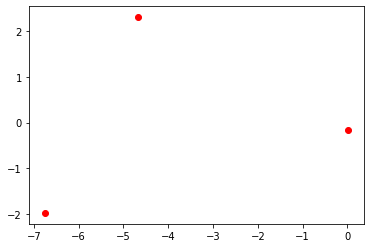

In [9]:
#visualize them

plt.scatter(two_examples[:,0],two_examples[:,1],color = 'red', label ='cluster B')
plt.scatter(other_example[0],other_example[1],color = 'red', label ='cluster A')
plt.show()

[[-6.76068856e+00 -1.97833447e+00]
 [ 2.97317235e-03 -1.56258359e-01]]


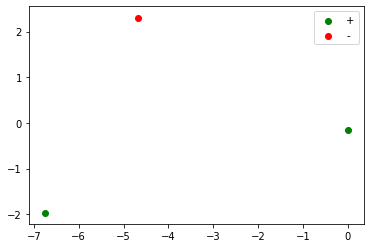

In [10]:
positive = np.concatenate(([two_examples[0]],[other_example]),axis=0)
negative= two_examples[1]
print(positive)
#visualize examples

plt.scatter(positive[:,0],positive[:,1],color = 'green', label ='+')
plt.scatter(negative[0],negative[1],color = 'red', label ='-')
plt.legend()
plt.show()

In [11]:
#train svm 
X = np.concatenate((positive,[negative]),axis=0)
y = np.array([1,1,-1])

def precomputed_Matrix(X1, X2, K_function=marginilized_Kernel):

    gram_matrix = np.zeros((X1.shape[0], X2.shape[0]))
    for i, x1 in enumerate(X1):
        for j, x2 in enumerate(X2):
            x1=x1.flatten()
            x2=x2.flatten()
            gram_matrix[i, j] = K_function(x1, x2)
    return gram_matrix

In [16]:
from sklearn import svm
'''clf = svm.SVC(kernel='linear',C=100)
clf.fit(svm_data,y_targets)
'''
clf = svm.SVC(kernel="precomputed", C=100)
gram = precomputed_Matrix(X,X)
clf.fit(gram,y)
#clf = svm.SVC(kernel =my_Kernel(em))
#clf.fit(X,y)
print(clf.get_params())
a = clf.dual_coef_[0]
sup = clf.support_
print(a)
print(sup)
b = clf.intercept_
print(b)
#clf.score(data_1,np.ones(data_1.shape[0]))

{'C': 100, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto_deprecated', 'kernel': 'precomputed', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
[-0.86054754  0.55180699  0.30874055]
[2 0 1]
[0.99822237]


In [17]:
#define indicator with kernel
def indicator(x,y):
    sup_vects = X[sup]
    kern = precomputed_Matrix(np.array([[x,y]]),sup_vects)
    result = np.dot(a,kern.T) + b # indicator(x) = <a,K(x,s)> + b
    return result


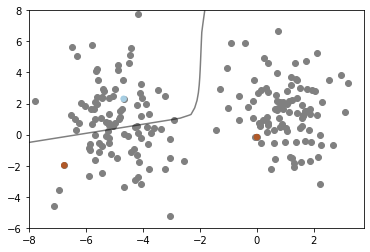

In [18]:
# visualize boundary 


plt.scatter(data_1[:,0],data_1[:,1],color = 'grey')
plt.scatter(data_2[:,0],data_2[:,1],color ='grey')

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)


# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(-8, 3, 30)
yy = np.linspace(-6, 8, 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
#Z = clf.decision_function(xy).reshape(XX.shape)
Z = np.vectorize(indicator)
print(Z)
# plot decision boundary and margins
ax.contour(XX, YY, Z(XX,YY), colors='k', levels=[0], alpha=0.5)
plt.show()

In [19]:

# this is an alternate way of defining my kernel ('in a more compact manner')
def my_Kernel(mixture):
    weights,means,covariances = mixture.weights_, mixture.means_, mixture.covariances_
    def responsibility(x,q):
        denom = 0
        K = weights.shape[0]
        result = np.zeros(K)
        for j in range(0,K):

            result[j] = weights[j] * multivariate_normal(means[j],covariances[j]).pdf(x)
            denom += result[j]
        result = result/denom
        return result[q]
    
    def marginilized_Kernel(x,y):
        K = covariances.shape[0]
        gram_matrix = np.zeros((x.shape[0], y.shape[0]))
        for i, x1 in enumerate(x):
            for j, x2 in enumerate(y):
                for q in range(0,K):
                    gram_matrix[i, j] += responsibility(x1,q) * responsibility(x2,q)*np.dot(x1, np.dot(np.linalg.inv(covariances[q]),x2))
        print(gram_matrix)
        return gram_matrix
    
    return marginilized_Kernel